In [4]:
import quandl
df = quandl.get('WIKI/GOOGL')
#老师 这个运行可能需要账户 我在有的电脑里面可以成功获取，但是有的电脑好像超过了最大限度

In [38]:
df.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2004-08-19,100.01,104.06,95.96,100.335,44659000.0,0.0,1.0,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,101.01,109.08,100.50,108.310,22834300.0,0.0,1.0,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,110.76,113.48,109.05,109.400,18256100.0,0.0,1.0,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,111.24,111.60,103.57,104.870,15247300.0,0.0,1.0,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,104.76,108.00,103.88,106.000,9188600.0,0.0,1.0,52.542193,54.167209,52.100830,53.164113,9188600.0


In [40]:
import math
import numpy as np
from sklearn import *

# 定义预测列变量，它存放研究对象的标签名
forecast_col = 'Adj. Close'
# 定义预测天数，这里设置为所有数据量长度的1%
forecast_out = int(math.ceil(0.01*len(df)))

# 只用到df中下面的几个字段
df1 = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]
# df1[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]
#df =  df['Volume']

df =df1
df1.head()

,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,
2004-08-19,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,52.542193,54.167209,52.100830,53.164113,9188600.0


In [41]:
# 构造两个新的列
# HL_PCT为股票最高价与最低价的变化百分比
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Close']) / df['Adj. Close'] * 100.0
# HL_PCT为股票收盘价与开盘价的变化百分比
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0

# 下面为真正用到的特征字段
df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]
# 因为scikit-learn并不会处理空数据，需要把为空的数据都设置为一个比较难出现的值，这里取-9999，
df.fillna(-99999, inplace=True)
# 用label代表该字段，是预测结果
# 通过让与Adj. Close列的数据往前移动1%行来表示
df['label'] = df[forecast_col].shift(-forecast_out)

# 最后生成真正在模型中使用的数据X和y和预测时用到的数据数据X_lately
X = np.array(df.drop(['label'], 1))
# TODO 此处尚有疑问
X = preprocessing.scale(X)
# 上面生成label列时留下的最后1%行的数据，这些行并没有label数据，因此我们可以拿他们作为预测时用到的输入数据
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# 抛弃label列中为空的那些行
df.dropna(inplace=True)
y = np.array(df['label'])

D:\Anaconda\envs\tensorflow130\lib\site-packages\pandas\core\frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
D:\Anaconda\envs\tensorflow130\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
D:\Anaconda\envs\tensorflow130\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

In [42]:
# scikit-learn从0.2版本开始废弃cross_validation，改用model_selection
from sklearn import preprocessing, model_selection, svm
from sklearn.linear_model import LinearRegression

# 开始前，先X和y把数据分成两部分，一部分用来训练，一部分用来测试
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

# 生成scikit-learn的线性回归对象
clf = LinearRegression(n_jobs=-1)
# 开始训练
clf.fit(X_train, y_train)
# 用测试数据评估准确性
accuracy = clf.score(X_test, y_test) 
# 进行预测
forecast_set = clf.predict(X_lately)

print(forecast_set, accuracy)

[1097.15948404 1070.37272574 1017.1270189  1057.59522427 1070.58983179
 1070.69877716 1088.75232996 1108.51828377 1111.46128499 1119.02216825
 1128.07987928 1126.63664302 1145.8560662  1161.3601872  1133.59493399
 1119.64292398 1085.64897348 1099.45854881 1110.72763536 1118.75391391
 1131.51965255 1146.65955735 1177.72502523 1182.58064944 1154.80238617
 1165.48086137 1167.3480825  1150.74716171 1116.24498539 1112.41301542
 1109.68976028 1067.6514062  1039.31444476 1070.47775644 1018.8695783 ] 0.9764035404753967


D:\Anaconda\envs\tensorflow130\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
D:\Anaconda\envs\tensorflow130\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


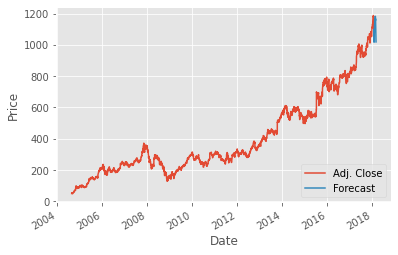

In [43]:
import matplotlib.pyplot as plt
from matplotlib import style
import datetime

# 修改matplotlib样式
style.use('ggplot')

one_day = 86400
# 在df中新建Forecast列，用于存放预测结果的数据
df['Forecast'] = np.nan
# 取df最后一行的时间索引
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
next_unix = last_unix + one_day

# 遍历预测结果，用它往df追加行
# 这些行除了Forecast字段，其他都设为np.nan
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    # [np.nan for _ in range(len(df.columns) - 1)]生成不包含Forecast字段的列表
    # 而[i]是只包含Forecast值的列表
    # 上述两个列表拼接在一起就组成了新行，按日期追加到df的下面
    df.loc[next_date] = [np.nan for _ in range(len(df.columns) - 1)] + [i]

# 开始绘图
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()